In [2]:
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf

In [3]:
train_dir = r'C:\Users\tusha\Desktop\Major Project\Flask_app\chest_xray\train'
val_dir = r'C:\Users\tusha\Desktop\Major Project\Flask_app\chest_xray\val'
test_dir = r'C:\Users\tusha\Desktop\Major Project\Flask_app\chest_xray\test'

In [4]:
IMG_HEIGHT = 224
IMG_WIDTH = 224

BATCH_SIZE = 32

In [5]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255,
)

val_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
)

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1/255
)

In [6]:
train_data = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

val_data = train_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

test_data = train_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    class_mode='binary',
    batch_size=BATCH_SIZE
)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


In [8]:
# mobilenet = tf.keras.applications.MobileNetV2(
#     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
#     include_top=False,
#     weights='imagenet',
#     pooling='avg'
# )

# mobilenet.trainable = False
# mobilenet = tf.keras.applications.ResNet50V2(
#     include_top=True,
#     weights="imagenet",
#     input_tensor=None,
#     input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
#     pooling=None,
#     classes=1000,
#     classifier_activation="softmax",
# )
# mobilenet.trainable = False
mobilenet = tf.keras.applications.VGG16(
    include_top=True,
    weights="imagenet",
    input_tensor=None,
       input_shape=(IMG_HEIGHT, IMG_WIDTH, 3),
    pooling=None,
    classes=1000,
    classifier_activation="softmax",
)
mobilenet.trainable = False



In [12]:
inputs = tf.keras.Input(shape=(IMG_HEIGHT, IMG_WIDTH, 3))

pretrained_model = mobilenet(inputs, training=False)

dense = tf.keras.layers.Dense(1024, activation='relu')(pretrained_model)

outputs = tf.keras.layers.Dense(1, activation='sigmoid')(dense)


model = tf.keras.Model(inputs, outputs)


print(model.summary())

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 resnet50v2 (Functional)     (None, 1000)              25613800  
                                                                 
 dense_2 (Dense)             (None, 1024)              1025024   
                                                                 
 dense_3 (Dense)             (None, 1)                 1025      
                                                                 
Total params: 26,639,849
Trainable params: 1,026,049
Non-trainable params: 25,613,800
_________________________________________________________________
None


In [13]:
EPOCHS = 50

model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

history = model.fit(
    train_data,
    validation_data=val_data,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',
            patience=3,
            restore_best_weights=True
        )
    ]
)

Epoch 1/50
163/163 [==============================] - 456s 3s/step - loss: 0.4042 - accuracy: 0.8184 - auc: 0.8539 - val_loss: 0.4452 - val_accuracy: 0.7500 - val_auc: 0.9297
Epoch 2/50
163/163 [==============================] - 424s 3s/step - loss: 0.3063 - accuracy: 0.8637 - auc: 0.9269 - val_loss: 0.4815 - val_accuracy: 0.7500 - val_auc: 0.9297
Epoch 3/50
163/163 [==============================] - 339s 2s/step - loss: 0.2734 - accuracy: 0.8785 - auc: 0.9416 - val_loss: 0.5058 - val_accuracy: 0.7500 - val_auc: 0.9219
Epoch 4/50
163/163 [==============================] - 436s 3s/step - loss: 0.2537 - accuracy: 0.8917 - auc: 0.9489 - val_loss: 0.5940 - val_accuracy: 0.7500 - val_auc: 0.9219


In [14]:
from sklearn.metrics import confusion_matrix

In [15]:
true_labels = test_data.labels
pred_labels = np.squeeze(np.array(model.predict(test_data) >= 0.5, dtype=int))

cm = confusion_matrix(true_labels, pred_labels) 

20/20 [==============================] - 55s 3s/step


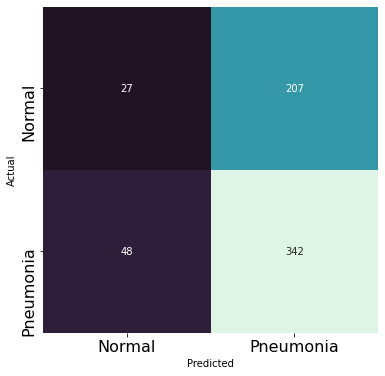

In [16]:
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='g', vmin=0, cmap='mako', cbar=False)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.xticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.yticks(np.arange(2) + 0.5, ['Normal', 'Pneumonia'], fontsize=16)
plt.show()

In [17]:
test_data.class_indices

{'normal': 0, 'pneumonia': 1}

In [18]:
results = model.evaluate(test_data, verbose=0)

accuracy = results[1]
auc = results[2]

In [19]:
tn, fp, fn, tp = cm.ravel()

precision = tp / (tp + fp)
recall = tp / (tp + fn)

In [20]:
print("Accuracy: {:.2f}".format(accuracy))
print("AUC: {:.2f}".format(auc))
print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))

Accuracy: 0.68
AUC: 0.82
Precision: 0.62
Recall: 0.88


In [ ]:
# model.save("model.h5")